In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ptb-ecg-database/README.md
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/SHA256SUMS.txt
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/RECORDS
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/README
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/CONTROLS
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/ptb.png
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0038lre.dat
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0026lre.xyz
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0029lre.xyz
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0026lre.dat
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0026lre.hea
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0/patient007/s0038lre.hea
/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-dat

In [20]:
import os
import pandas as pd
import numpy as np
import re

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
from sklearn.impute import SimpleImputer

# **EDA**
Here we analyze the data.

In [3]:
def list_subdirectories(path):
    try:
        if not os.path.isdir(path):
            print(f"Error: The path '{path}' is not a valid directory.")
            return None

        entries = os.listdir(path)
        subdirectories = [entry for entry in entries if os.path.isdir(os.path.join(path, entry))]
        subdirectories.sort()
        
        return subdirectories

    except FileNotFoundError:
        print(f"Error: The path '{path}' was not found.")
        return None
    except PermissionError:
        print(f"Error: Permission denied to access '{path}'.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [4]:
path = "/kaggle/input/ptb-ecg-database/ptb-diagnostic-ecg-database-1.0.0"
subdirectories = list_subdirectories(path)
patients = pd.DataFrame(subdirectories)
patients

,0
0,patient001
1,patient002
2,patient003
3,patient004
4,patient005
...,...
285,patient290
286,patient291
287,patient292
288,patient293


In [5]:
def find_hea_files_in_subdirs(base_path):
    
    subdirs = list_subdirectories(base_path)
    if subdirs is None:
        return None

    hea_files_by_dir = {}

    for subdir in subdirs:
        try:
            subdir_path = os.path.join(base_path, subdir)
            all_files = os.listdir(subdir_path)
            
            hea_files = [f for f in all_files if f.endswith('.hea') and os.path.isfile(os.path.join(subdir_path, f))]
            hea_files.sort()
            
            hea_files_by_dir[subdir] = hea_files
        except PermissionError:
            print(f"Warning: Permission denied for directory '{subdir}'. Skipping.")
            hea_files_by_dir[subdir] = ["--> Permission Denied"]
        except Exception as e:
            print(f"Warning: Could not process directory '{subdir}': {e}. Skipping.")
            hea_files_by_dir[subdir] = [f"--> Error: {e}"]
            
    return hea_files_by_dir

In [6]:
patients_header = find_hea_files_in_subdirs(path)
patients_header

{'patient001': ['s0010_re.hea', 's0014lre.hea', 's0016lre.hea'],
 'patient002': ['s0015lre.hea'],
 'patient003': ['s0017lre.hea'],
 'patient004': ['s0020are.hea', 's0020bre.hea'],
 'patient005': ['s0021are.hea',
  's0021bre.hea',
  's0025lre.hea',
  's0031lre.hea',
  's0101lre.hea'],
 'patient006': ['s0022lre.hea', 's0027lre.hea', 's0064lre.hea'],
 'patient007': ['s0026lre.hea',
  's0029lre.hea',
  's0038lre.hea',
  's0078lre.hea'],
 'patient008': ['s0028lre.hea', 's0037lre.hea', 's0068lre.hea'],
 'patient009': ['s0035_re.hea'],
 'patient010': ['s0036lre.hea', 's0042lre.hea', 's0061lre.hea'],
 'patient011': ['s0039lre.hea',
  's0044lre.hea',
  's0049lre.hea',
  's0067lre.hea'],
 'patient012': ['s0043lre.hea', 's0050lre.hea'],
 'patient013': ['s0045lre.hea', 's0051lre.hea', 's0072lre.hea'],
 'patient014': ['s0046lre.hea', 's0056lre.hea', 's0071lre.hea'],
 'patient015': ['s0047lre.hea', 's0057lre.hea', 's0152lre.hea'],
 'patient016': ['s0052lre.hea', 's0060lre.hea', 's0076lre.hea'],
 'pa

In [7]:
def extract_localization_from_files(hea_data, base_path):
    
    data_by_patient = {}
    
    if not hea_data:
        return {}

    for directory, file_list in hea_data.items():
        
        grouped_by_info = {}

        for file_name in file_list:
            full_path = os.path.join(base_path, directory, file_name)
            
            acute_loc = "Not specified"
            former_loc = "Not specified"
            disease = "Not specified"
            age = "Not specified"
            sex = "Not specified"
            smoker = "Not specified"
            vessels = "Not specified"
            additional_diagnoses = "Not specified"


            if file_name.startswith("-->"):
                
                acute_loc, former_loc, disease, age, sex, smoker, vessels, additional_diagnoses = ["N/A (Previous error)"] * 8
            else:
                try:
                    with open(full_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                        
                        # Extract all fields using regex
                        acute_match = re.search(r'# Acute infarction \(localization\): (.*)', content)
                        if acute_match: acute_loc = acute_match.group(1).strip()
                        
                        former_match = re.search(r'# Former infarction \(localization\): (.*)', content)
                        if former_match: former_loc = former_match.group(1).strip()
                        
                        dis_match = re.search(r'# Reason for admission: (.*)', content)
                        if dis_match: disease = dis_match.group(1).strip()

                        age_match = re.search(r'# age: (.*)', content)
                        if age_match: age = age_match.group(1).strip()

                        sex_match = re.search(r'# sex: (.*)', content)
                        if sex_match: sex = sex_match.group(1).strip()

                        smoker_match = re.search(r'# Smoker: (.*)', content)
                        if smoker_match: smoker = smoker_match.group(1).strip()

                        vessels_match = re.search(r'# Number of coronary vessels involved: (.*)', content)
                        if vessels_match: vessels = vessels_match.group(1).strip()

                        additional_dx_match = re.search(r'# Additional diagnoses: (.*)', content)
                        if additional_dx_match: additional_diagnoses = additional_dx_match.group(1).strip()

                except Exception as e:
                    acute_loc, former_loc, disease, age, sex, smoker, vessels, additional_diagnoses = [f"--> Error: {e}"] * 8
            
            info_tuple = (acute_loc, former_loc, disease, age, sex, smoker, vessels, additional_diagnoses)
            if info_tuple not in grouped_by_info:
                grouped_by_info[info_tuple] = []
            grouped_by_info[info_tuple].append(file_name)
        
        patient_summary_list = []
        for info, files in grouped_by_info.items():
            
            unpacked_info = info
            patient_summary_list.append(unpacked_info + (len(files), files))
            
        data_by_patient[directory] = patient_summary_list
            
    return data_by_patient

In [8]:
patients_localization = extract_localization_from_files(patients_header,path)
patients_localization

{'patient001': [('infero-latera',
   'no',
   'Myocardial infarction',
   '81',
   'female',
   'no',
   '1',
   'Diabetes mellitus',
   3,
   ['s0010_re.hea', 's0014lre.hea', 's0016lre.hea'])],
 'patient002': [('anterior',
   'no',
   'Myocardial infarction',
   '58',
   'female',
   'yes',
   '1',
   'Arterial hypertension, Adiposis hepatis, Gastritis',
   1,
   ['s0015lre.hea'])],
 'patient003': [('infero-postero-lateral',
   'no',
   'Myocardial infarction',
   '63',
   'male',
   'yes',
   '1',
   'no',
   1,
   ['s0017lre.hea'])],
 'patient004': [('antero-septal',
   'no',
   'Myocardial infarction',
   '69',
   'male',
   'no',
   '1',
   'Arterial hypertension, Obesity',
   2,
   ['s0020are.hea', 's0020bre.hea'])],
 'patient005': [('anterior',
   'no',
   'Myocardial infarction',
   '74',
   'male',
   'no',
   '2',
   'Skoliosis',
   5,
   ['s0021are.hea',
    's0021bre.hea',
    's0025lre.hea',
    's0031lre.hea',
    's0101lre.hea'])],
 'patient006': [('anterior',
   'inferi

In [9]:
def convert_to_dataframe(patient_data):
    
    try:
        import pandas as pd
    except ImportError:
        return None

    data_for_df = []
    for patient, summary_list in patient_data.items():
        if summary_list:
            for data_tuple in summary_list:
                (acute_loc, former_loc, disease, age, sex, smoker, 
                 vessels, additional_diagnoses, count, files) = data_tuple
                
                data_for_df.append({
                    'patient': patient,
                    'age': age,
                    'sex': sex,
                    'disease': disease,
                    'acute_localization': acute_loc,
                    'former_localization': former_loc,
                    'additional_diagnoses': additional_diagnoses,
                    'smoker': smoker,
                    'vessels_involved': vessels,
                    'file_count': count,
                    'hea_files': ", ".join(files)
                })
        else:
            data_for_df.append({
                'patient': patient,
                'age': 'N/A',
                'sex': 'N/A',
                'disease': 'N/A',
                'acute_localization': 'N/A',
                'former_localization': 'N/A',
                'additional_diagnoses': 'N/A',
                'smoker': 'N/A',
                'vessels_involved': 'N/A',
                'file_count': 0,
                'hea_files': ''
            })

    return pd.DataFrame(data_for_df)

In [10]:
patient_details = convert_to_dataframe(patients_localization)
patient_details.head()

,patient,age,sex,disease,acute_localization,former_localization,additional_diagnoses,smoker,vessels_involved,file_count,hea_files
0,patient001,81,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,no,1,3,"s0010_re.hea, s0014lre.hea, s0016lre.hea"
1,patient002,58,female,Myocardial infarction,anterior,no,"Arterial hypertension, Adiposis hepatis, Gastr...",yes,1,1,s0015lre.hea
2,patient003,63,male,Myocardial infarction,infero-postero-lateral,no,no,yes,1,1,s0017lre.hea
3,patient004,69,male,Myocardial infarction,antero-septal,no,"Arterial hypertension, Obesity",no,1,2,"s0020are.hea, s0020bre.hea"
4,patient005,74,male,Myocardial infarction,anterior,no,Skoliosis,no,2,5,"s0021are.hea, s0021bre.hea, s0025lre.hea, s003..."


In [58]:
patient_details.isin([np.nan,"unknown","no","","N/A","n/a","?","-"]).sum()/patient_detail.shape[0] * 100

patient                  0.000000
age                      5.172414
sex                      3.103448
disease                  7.586207
acute_localization      56.206897
former_localization     84.137931
additional_diagnoses    40.689655
smoker                  74.827586
vessels_involved        54.482759
file_count               0.000000
hea_files                0.000000
dtype: float64

In [82]:
patient_detail = patient_details.drop(columns=['vessels_involved','file_count','smoker'])
final_patient_details = patient_detail[patient_detail['disease'].isin(["Myocardial infarction", "Healthy control"])]
final_patient_details.head()

,patient,age,sex,disease,acute_localization,former_localization,additional_diagnoses,hea_files
0,patient001,81,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,"s0010_re.hea, s0014lre.hea, s0016lre.hea"
1,patient002,58,female,Myocardial infarction,anterior,no,"Arterial hypertension, Adiposis hepatis, Gastr...",s0015lre.hea
2,patient003,63,male,Myocardial infarction,infero-postero-lateral,no,no,s0017lre.hea
3,patient004,69,male,Myocardial infarction,antero-septal,no,"Arterial hypertension, Obesity","s0020are.hea, s0020bre.hea"
4,patient005,74,male,Myocardial infarction,anterior,no,Skoliosis,"s0021are.hea, s0021bre.hea, s0025lre.hea, s003..."


In [83]:
final_patient_details.isin([np.nan,"unknown","no","","N/A","n/a","?","-"]).sum()/final_patient_details.shape[0] * 100

patient                  0.0
age                      3.0
sex                      0.0
disease                  0.0
acute_localization      36.5
former_localization     77.0
additional_diagnoses    44.0
hea_files                0.0
dtype: float64

In [84]:
patients = final_patient_details

Dealing with **age** data imbalance.

In [85]:
patients = patients.replace('n/a', np.nan)
patients['age'] = SimpleImputer(strategy='mean').fit_transform(patients[['age']])
patients

,patient,age,sex,disease,acute_localization,former_localization,additional_diagnoses,hea_files
0,patient001,81.0,female,Myocardial infarction,infero-latera,no,Diabetes mellitus,"s0010_re.hea, s0014lre.hea, s0016lre.hea"
1,patient002,58.0,female,Myocardial infarction,anterior,no,"Arterial hypertension, Adiposis hepatis, Gastr...",s0015lre.hea
2,patient003,63.0,male,Myocardial infarction,infero-postero-lateral,no,no,s0017lre.hea
3,patient004,69.0,male,Myocardial infarction,antero-septal,no,"Arterial hypertension, Obesity","s0020are.hea, s0020bre.hea"
4,patient005,74.0,male,Myocardial infarction,anterior,no,Skoliosis,"s0021are.hea, s0021bre.hea, s0025lre.hea, s003..."
...,...,...,...,...,...,...,...,...
285,patient290,60.0,male,Myocardial infarction,antero-septal,inferior,unknown,s0553_re.hea
286,patient291,69.0,male,Myocardial infarction,inferior,inferior,unknown,s0554_re.hea
287,patient292,66.0,male,Myocardial infarction,antero-lateral,no,Arterial hypertension,"s0555_re.hea, s0556_re.hea"
288,patient293,75.0,male,Myocardial infarction,antero-lateral,no,unknown,"s0557_re.hea, s0558_re.hea"


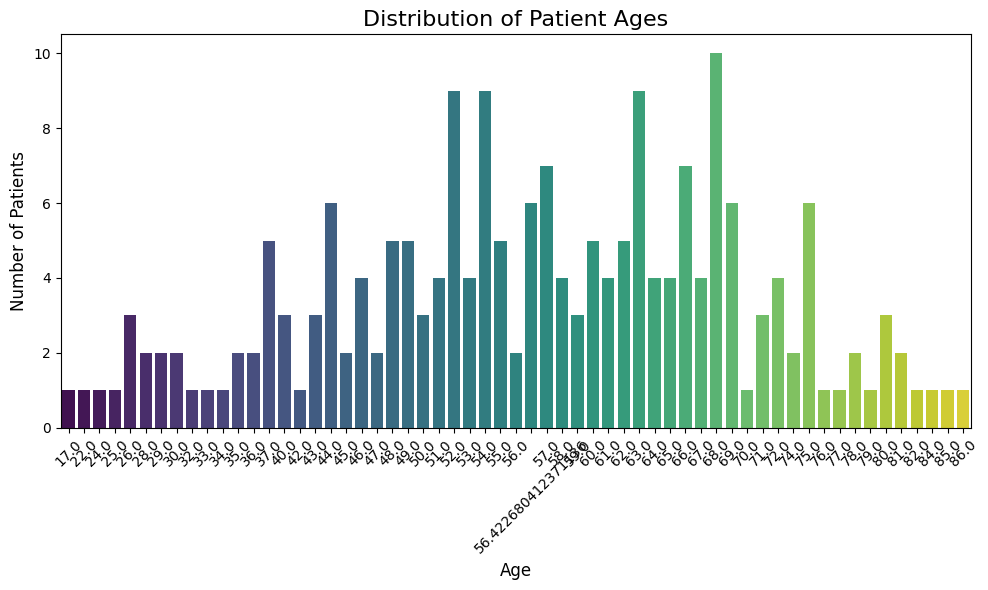

In [87]:
plt.figure(figsize=(10, 6))
sns.countplot(x='age', data=patients, palette='viridis')

plt.title('Distribution of Patient Ages', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.xticks(rotation=45) # Rotate x-axis labels if they overlap
plt.tight_layout() # Adjust layout to make room for labels

plt.show()